<a href="https://colab.research.google.com/github/Yuvraj2410/PINN_elasticity/blob/main/PINN_elasticity_any_shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sciann as sn
import numpy as np
import matplotlib.pyplot as plt

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0] 



In [ ]:
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sciann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 21.0 MB/s eta 0:00:00


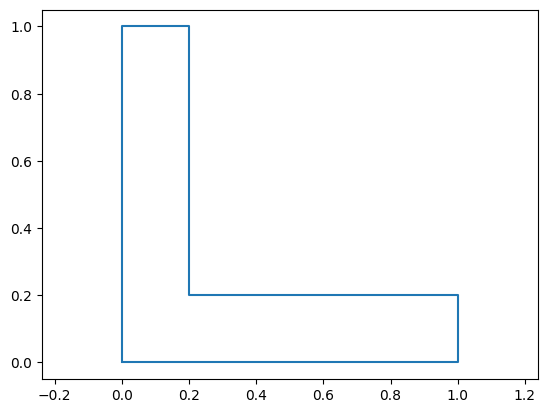

In [ ]:
import numpy as np
from shapely.geometry import Polygon

# Define the length of the L shape's arm and the width of the L shape
arm_length = 1
arm_width = 0.2

# Define the number of points to generate on the boundary
num_points = 500

# Define the L shape polygon
poly_coords = [(0,0), (0,arm_length), (arm_width, arm_length),(arm_width,arm_width), (arm_length,arm_width),(arm_length,0), (0,0)]
poly = Polygon(poly_coords)

# Generate the specified number of points on the polygon boundary
x2, y2 = [], []
for i, dist in zip(range(num_points), np.linspace(0, poly.boundary.length, num_points, endpoint=False)):
    point = poly.boundary.interpolate(dist)
    x2.append(point.x)
    y2.append(point.y)

# Plot the points to visualize the L shape
x2 = np.array(x2)
y2 = np.array(y2)

plt.plot(x2, y2, '-')
plt.axis('equal')
plt.show()

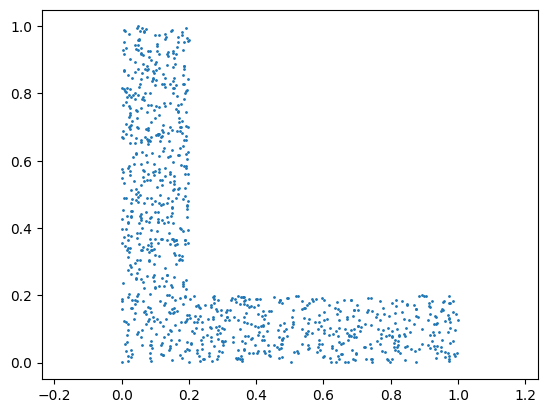

In [ ]:
from shapely.geometry import Polygon, Point

# Define the length of the L shape's arm and the width of the L shape
arm_length = 1
arm_width = 0.2

# Define the number of points to use for each arm
num_points = 1000

# Define the L shape polygon
poly_coords = [(0,0), (0,arm_length), (arm_width, arm_length),(arm_width,arm_width), (arm_length,arm_width),(arm_length,0), (0,0)]
poly = Polygon(poly_coords)

# Generate random points inside the polygon
points = []
while len(points) < num_points:
    random_point = Point(np.random.uniform(0, arm_length), np.random.uniform(0, arm_length))
    if random_point.within(poly):
        points.append(random_point)

# Extract the x and y coordinates of the points
x1 = [point.x for point in points]
y1 = [point.y for point in points]

# Plot the points to visualize the L shape
x1 = np.array(x1)
y1 = np.array(y1)
plt.plot(x1, y1, '.', markersize=2)
plt.axis('equal')
plt.show()

In [ ]:
from itertools import cycle
cycol = cycle('bgrcmk')
class DataGeneratorXY:
  def __init__(self,
               x1,y1,x2,y2,
               targets=['domain', 'bc'],
               num_sample=1000):
    'Initialization'
    self.Xdomain = x1
    self.Ydomain = y1
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_data(self):
    # distribute half inside domain half on the boundary

    counter = 0
    # domain points
    x_dom = x1
    y_dom = y1
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # bc points
    # left bc points
    x_bc = x2
    y_bc = y2
    ids_bc = np.arange(x_bc.shape[0]) + counter
    counter += ids_bc.size

    ids_all = np.concatenate([ids_dom, ids_bc])

    ids = {
        'domain': ids_dom,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_bc]).reshape(-1,1),
        np.concatenate([y_dom, y_bc]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )

    return input_data, target_data

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = self.input_data[1][ids,:]
      plt.scatter(x_data, y_data)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, y_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()

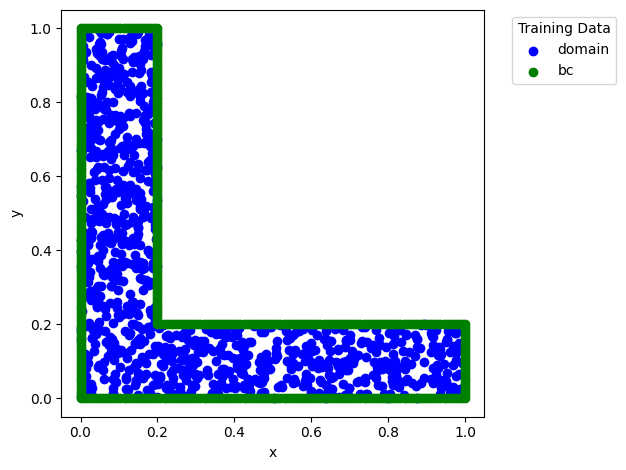

In [ ]:
dg = DataGeneratorXY(x1,y1,x2,y2)
dg.plot_data()
lmbd = 1.0
mu = 0.5

In [ ]:
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh')
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')
Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

C11 = (2*mu + lmbd)
C12 = lmbd
C33 = 2*mu

Exx = sn.diff(Uxy, x)
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

c1 = sn.Tie(Sxx, Exx*C11 + Eyy*C12)
c2 = sn.Tie(Syy, Eyy*C11 + Exx*C12)
c3 = sn.Tie(Sxy, Exy*C33)

Fx = 2000

Fy = 2000

Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy

BC_1 = (x==0)*(Vxy)
BC_2 = (y==0)*(Uxy)
BC_3 = (x==0.2 and y > 0.2)*(Sxx)
BC_4 = (y==0.2 and x > 0.2)*(Sxy)


targets = [Lx, Ly, c1, c2, c3,
           BC_1,BC_2,BC_3,BC_4]

In [ ]:
dg = DataGeneratorXY(x1,y1,x2,y2 ,
                     targets=5*['domain'] + 4*['bc'])

input_data, target_data = dg.get_data()

In [ ]:
m = sn.SciModel([x, y], targets)
m.train(input_data, target_data, batch_size=100, epochs=10000)

Streaming output truncated to the last 5000 lines.
15/15 [==============================] - 0s 19ms/step - batch: 7.0000 - size: 100.0000 - loss: 4174.1575 - sub_4_loss: 1168.0253 - sub_5_loss: 734.1954 - sub_loss: 124.9437 - sub_2_loss: 103.6562 - sub_3_loss: 68.3689 - mul_7_loss: 20.4376 - mul_8_loss: 549.8610 - mul_9_loss: 893.3386 - mul_10_loss: 511.3311 - lr: 0.0010 - time: 0.3456
Epoch 7502/10000
15/15 [==============================] - 0s 15ms/step - batch: 7.0000 - size: 100.0000 - loss: 3494.3164 - sub_4_loss: 663.2587 - sub_5_loss: 601.3426 - sub_loss: 103.8878 - sub_2_loss: 90.6717 - sub_3_loss: 66.9721 - mul_7_loss: 20.4746 - mul_8_loss: 551.0055 - mul_9_loss: 903.6341 - mul_10_loss: 493.0693 - lr: 0.0010 - time: 0.2479
Epoch 7503/10000
15/15 [==============================] - 0s 15ms/step - batch: 7.0000 - size: 100.0000 - loss: 3076.7269 - sub_4_loss: 400.3553 - sub_5_loss: 527.5608 - sub_loss: 78.4937 - sub_2_loss: 61.0858 - sub_3_loss: 54.5449 - mul_7_loss: 20.8591 - mu

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(0,1,200), np.linspace(0,1,200))

In [ ]:
u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])

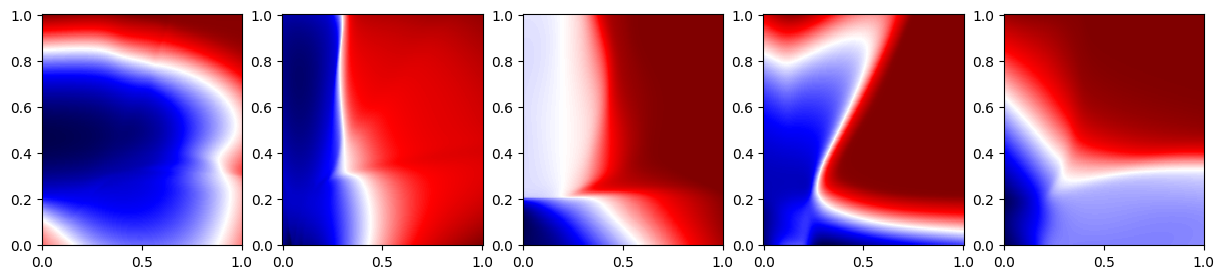

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(15,3))
ax[0].pcolor(x_test, y_test, u_test, cmap='seismic', shading='auto')
ax[1].pcolor(x_test, y_test, v_test, cmap='seismic', shading='auto')
ax[2].pcolor(x_test, y_test, sxx_test, cmap='seismic', shading='auto')
ax[3].pcolor(x_test, y_test, syy_test, cmap='seismic', shading='auto')
ax[4].pcolor(x_test, y_test, sxy_test, cmap='seismic', shading='auto')
plt.show()